In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
class op(object):
    def __init__(self, epochs, inmodal_warmup, multimodal_warmup, loader_update_freq, update_filter_ratio, filter_ratio):
            self.epochs = epochs
            self.inmodal_warmup = inmodal_warmup
            self.multimodal_warmup = multimodal_warmup
            self.loader_update_freq = loader_update_freq
            self.update_filter_ratio = update_filter_ratio
            self.filter_ratio = filter_ratio
            

In [3]:
file1 = open('/home/hyang/NNCLIP/CyCLIP/logs/SafeCLIP_1M_test/output.log', 'r')
Lines = file1.readlines()
count = 0
learn_rate_inmodal = []
learn_rate_crossmodal = []
cross_modal = True
# Strips the newline character
for line in Lines:
    a = re.search("Learning Rate:", line)
    b = re.search("Multimodal", line)
    c = re.search("Inmodal", line)
    if b:
        cross_modal = True
    if c:
        cross_modal = False
    if a and cross_modal:
        learn_rate_crossmodal.append(float(line.strip()[-11:]))
    elif a:
        # print(line)
        # print(cross_modal)
        learn_rate_inmodal.append(float(line.strip()[-11:]))

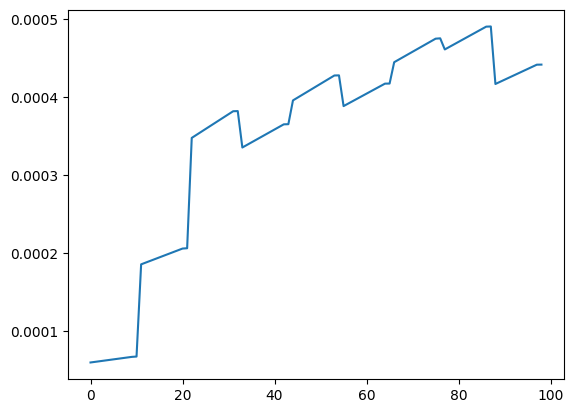

In [4]:
plt.plot(learn_rate_crossmodal)

In [6]:
def calcualte_num_batches(options, num_batches):
    update_epoch = options.epochs - options.inmodal_warmup - options.multimodal_warmup
    num_update = update_epoch // options.loader_update_freq
    left_off_epoch = update_epoch % options.loader_update_freq
    total_step = 0
    for i in range(num_update):
        total_step = total_step + (i * options.update_filter_ratio + options.filter_ratio) * options.loader_update_freq * num_batches
    total_step =  total_step + ((i+1) * options.update_filter_ratio + options.filter_ratio) * num_batches * left_off_epoch
    return total_step


def cosine_scheduler_mock(base_lr, post_lr, num_warmup_steps, total_steps):
    def _scheduler(current_step, lr_adjust=False):
        if lr_adjust:
            lr = post_lr
        elif(current_step < num_warmup_steps):
            lr = base_lr * (current_step + 1) / num_warmup_steps
        else:
            n = current_step - num_warmup_steps
            d = total_steps - num_warmup_steps
            lr = 0.5 * (1 + np.cos(np.pi * n / d)) * base_lr
        return lr, current_step
    return _scheduler

In [7]:
options = op(32, 5, 1, 1, 0.01, 0.15)
epochs = list(range(7,32))
total = calcualte_num_batches(options, 3909)
train_num_batches = total // (options.epochs - options.inmodal_warmup - options.multimodal_warmup)
num_batches = list(range(585, 3200, 39))
# total = 1954 * 32
scheduler = cosine_scheduler_mock(base_lr = 0.0005, post_lr = 5e-06, num_warmup_steps = 8000, total_steps = total)

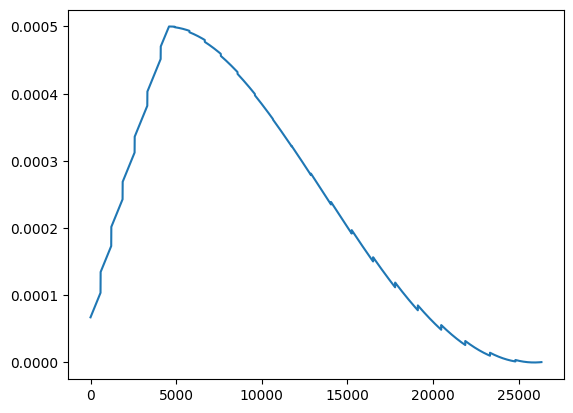

In [10]:
total_lr = []
total_step = []
for i in epochs:
    batch_size = num_batches[i-7]
    for j in range(batch_size):
        step = train_num_batches * (i - 6) + j
        lr, current_step = scheduler(step)
        total_lr.append(lr) 
        total_step.append(current_step) 

plt.plot(total_lr)